# Carter Thiel
## Astronomy Image Stacking Software
### May 13, 2024


### Progress:

The main basic goal of my project from the beginning was to create a similar software to one that I use called DeepSkyStacker, which aligns and stacks images. I learned that DeepSkyStacker uses much more well rounded techniques like star formation matching and star detection. From the start I wanted to replicate it using feature matching, which presented a challenge. Additional challenges like implementing calibration frames were optional if I had time. The feature matching and stacking was what ended up being the challenge of this project and the calibration frames were actually somewhat easy to implement. I would say I fulfilled my original goals of the project.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from skimage.exposure import match_histograms
from scipy.ndimage import median_filter

Here the light and dark frame FITS file are read in to be used in the project. Colab did not like FITS and this required using an imported tool for them to be loaded. Normalizing the FITS images was important so that the images were compatible with image processing and visualizaton tools in colab like openCV.

In [ ]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".fits"):
            with fits.open(os.path.join(folder, filename)) as hdul:
                data = hdul[0].data
                norm_data = cv2.normalize(data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
                norm_data = norm_data.astype(np.uint8)
                images.append(norm_data)
    return images

In [ ]:
def load_and_stack_dark_frames(dark_folder):
    dark_images = load_images(dark_folder)
    if dark_images:
        stacked_dark = np.mean(np.array(dark_images), axis=0).astype(np.uint8)
        return stacked_dark
    else:
        print("No dark frames found.")
        return None

This rough align method was created to help create accurate matches between the images and ended up being crucial for stacking. It roughly aligns the two images being compared for feature matches about their centers. This way, when matches are created, the bad matches can be filtered out if they are more than a few pixels away from each other on the roughly aligned image. Light frames end up being very similar to each other with very little movement from the stars across all of the images. So accurate matches would be the ones with very little movement from the star in the first image overlapped with the same star in the image being compared.

It uses a translation matrix to center image 2 relative to image 1. Then uses warpAffine to produce the roughly aligned image to be used in the compute homography function.

In [ ]:
def rough_align(image1, image2):
    h1, w1 = image1.shape
    h2, w2 = image2.shape
    translation_matrix = np.float32([[1, 0, (w1 - w2) // 2], [0, 1, (h1 - h2) // 2]])
    rough_aligned_image2 = cv2.warpAffine(image2, translation_matrix, (w1, h1))
    return rough_aligned_image2

The compute_homography function is important to find and apply precise transformations to align the images accurately. I found that SIFT features worked well for finding the reliable features, even though ORB or AKAZE would have likely worked as well. The implementation of the rough_align logic was crucial and feature matching would not be accurate otherwise. Which is why I was stuck on this for a long time, because I was not finding accurate matches. If the distance between two found matches are more than a small distance apart on the roughly aligned images, then they are discarded. The homography is then computed and returned.

In [ ]:
def compute_homography(next_image, base_image):
    MAX_FEATURES = 5000
    GOOD_MATCH_PERCENT = 0.2

    alg = cv2.SIFT_create(nfeatures=MAX_FEATURES)
    kp1, des1 = alg.detectAndCompute(next_image, None)
    kp2, des2 = alg.detectAndCompute(base_image, None)

    rough_aligned_image = rough_align(base_image, next_image)

    kp2_rough, des2_rough = alg.detectAndCompute(rough_aligned_image, None)
    if des2_rough is None:
        return None, None

    bf_rough = cv2.BFMatcher(cv2.NORM_L2)
    matches_rough = bf_rough.knnMatch(des1, des2_rough, k=2)

    good_matches_rough = []
    for m, n in matches_rough:
        if m.distance < 0.75 * n.distance:
            good_matches_rough.append(m)

    distance_threshold = 2
    accurate_matches = []
    for m in good_matches_rough:
        p1 = np.float32(kp1[m.queryIdx].pt)
        p2 = np.float32(kp2_rough[m.trainIdx].pt)
        if np.linalg.norm(p1 - p2) < distance_threshold:
            accurate_matches.append(m)

    if len(accurate_matches) > 5:
        points1 = np.float32([kp1[m.queryIdx].pt for m in accurate_matches]).reshape(-1, 1, 2)
        points2 = np.float32([kp2_rough[m.trainIdx].pt for m in accurate_matches]).reshape(-1, 1, 2)

        M, inliers = cv2.findHomography(points1, points2, cv2.RANSAC, 3.0)

        if inliers is not None and np.sum(inliers) > 5:
            return M, rough_aligned_image
        else:
            return None, None
    else:
        return None, None

The align_and_stack function aligning the series of loaded images and then stacking the aligned images into one. I chose to use the first loaded image as the reference/baseline image to which all the other images were aligned to. If dark frames are present, it subtracts them from each light frame to reduce noise. I also matched the histograms of all the images before aligning and stacking to ensure consistent brightness and contrast across all of the images. Even with highly accurate matches there was still tons of artifacts in the final stacked image and during the stacking process. The subtracted dark frames helped to reduce these artifacts.

In [ ]:
def align_and_stack(images, dark_frame=None):
    ref_image = images[0]
    aligned_images = []

    for i, img in enumerate(images):
        if dark_frame is not None:
            img = cv2.subtract(img, dark_frame)

        img = match_histograms(img, ref_image, channel_axis=-1)
        M, rough_aligned_image = compute_homography(img, ref_image)
        if M is not None:
            aligned_image = cv2.warpPerspective(img, M, (ref_image.shape[1], ref_image.shape[0]), flags=cv2.INTER_LINEAR)
            aligned_images.append(aligned_image)
        else:
            print(f"Skipping image {i} due to insufficient alignment")

    #aligned_images = [cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8) for img in aligned_images]

    stacked_image = np.mean(np.array(aligned_images), axis=0).astype(np.uint8)

    return stacked_image

Function to apply a stretch to the images to view them in colab, or else they would be too dark. Normally, you would keep them dark and process them in a different software to finally see your results. I had trouble finding a good way to stretch the images. Sometimes equalizeHist would overexpose the images.

In [ ]:
def apply_clahe_and_equalize(image):
    if image.ndim > 2 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray)
    stretched_image = cv2.equalizeHist(enhanced_image)
    return stretched_image

Here are functions to calculate the signal to noise ratio and contrast to noise ratio in the completed images. This helped me to conclude whether or not the stacking process and calibration frames were really doing anything. Higher values are better.

In [ ]:
def calculate_snr(image):
    signal_region = image > np.percentile(image, 99)
    if np.sum(signal_region) == 0:
        return np.nan
    signal = np.mean(image[signal_region])
    background_region = ~signal_region
    noise = np.std(image[background_region])
    if noise == 0:
        return np.nan
    snr = signal / noise
    return snr

def calculate_cnr(image):
    signal_region = image > np.percentile(image, 99)
    if np.sum(signal_region) == 0:
        return np.nan
    mean_signal = np.mean(image[signal_region])
    background_region = ~signal_region
    mean_background = np.mean(image[background_region])
    noise = np.std(image[background_region])
    if noise == 0:
        return np.nan
    cnr = (mean_signal - mean_background) / noise
    return cnr

Main code to run the code. Here I call all of the functions and also print a single light frame to compare with the stacked images.

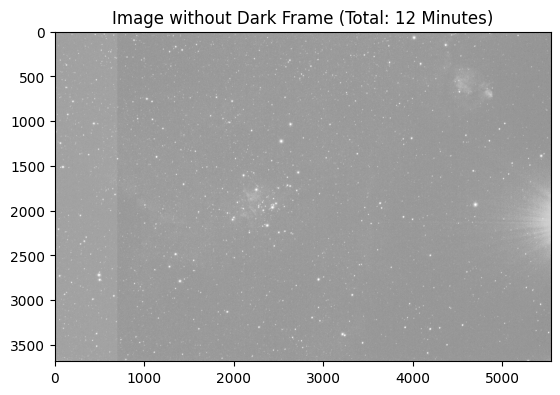

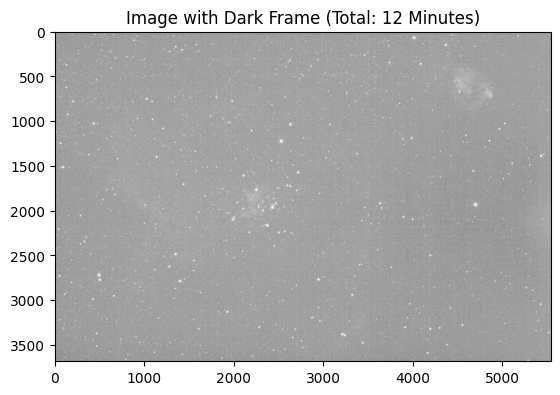

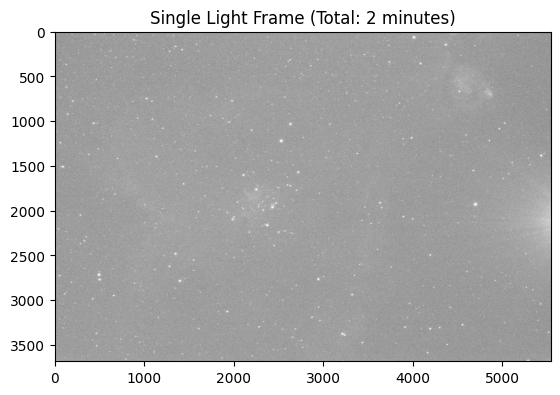

SNR of Single Light Frame: 3.4424337385626873
SNR of Stacked Image without Dark Frame: 3.525145949561615
SNR of Stacked Image with Dark Frame: 3.641813893691838
CNR of Single Light Frame: 1.3148023186042475
CNR of Stacked Image without Dark Frame: 1.3726834826104999
CNR of Stacked Image with Dark Frame: 1.3616299954683495
Alignment and stacking completed.


In [ ]:
folder_path = '/content/astro/lights'
dark_folder_path = '/content/astro/darks'

images = load_images(folder_path)
stacked_dark = load_and_stack_dark_frames(dark_folder_path)

stacked_image_no_dark = align_and_stack(images, dark_frame=None)
stacked_image_with_dark = align_and_stack(images, dark_frame=stacked_dark)

stacked_stretch_no_dark = apply_clahe_and_equalize(stacked_image_no_dark)
stacked_stretch_with_dark = apply_clahe_and_equalize(stacked_image_with_dark)

# Final images
plt.imshow(stacked_stretch_no_dark, cmap='gray')
plt.title("Image without Dark Frame (Total: 12 Minutes)")
plt.show()

plt.imshow(stacked_stretch_with_dark, cmap='gray')
plt.title("Image with Dark Frame (Total: 12 Minutes)")
plt.show()

# Single light frame for comparison
one_frame_path = '/content/astro/lights/2024-02-14_19-58-26__-10.10_120.00s_0000.fits'

with fits.open(one_frame_path) as hdul:
    data = hdul[0].data
    norm_data = cv2.normalize(data, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    norm_data = norm_data.astype(np.uint8)

stretched_one_frame = apply_clahe_and_equalize(norm_data)

plt.imshow(stretched_one_frame, cmap='gray')
plt.title("Single Light Frame (Total: 2 minutes)")
plt.show()

# SNR and CNR calculations
snr_single = calculate_snr(stretched_one_frame)
snr_stacked_no_dark = calculate_snr(stacked_stretch_no_dark)
snr_stacked_with_dark = calculate_snr(stacked_stretch_with_dark)
cnr_single = calculate_cnr(stretched_one_frame)
cnr_stacked_no_dark = calculate_cnr(stacked_stretch_no_dark)
cnr_stacked_with_dark = calculate_cnr(stacked_stretch_with_dark)

print(f"SNR of Single Light Frame: {snr_single}")
print(f"SNR of Stacked Image without Dark Frame: {snr_stacked_no_dark}")
print(f"SNR of Stacked Image with Dark Frame: {snr_stacked_with_dark}")
print(f"CNR of Single Light Frame: {cnr_single}")
print(f"CNR of Stacked Image without Dark Frame: {cnr_stacked_no_dark}")
print(f"CNR of Stacked Image with Dark Frame: {cnr_stacked_with_dark}")

print("Alignment and stacking completed.")

From the images and noise ratio data you can see the difference stacking the images made. In the stacked image with no dark frames, there are large artifacts like the strange gradient on the left hand side and the amp glow from the camera senser on the right side of the image. Once the dark frames are implemented, gradient and amp glow artifacts are nearly completely gone. While not very noticable, the stacked images likely brought out more light data than the single light frame image. Using an actual processing software and stretching the images further would better reveal the benefits from the stacked images, like reduced noise and more detail. You can also see that the stacked images with no dark frames performed much better than the single light frame for the signal to noise ratio values. The stacked images with dark frames performed even better, and the same goes for the contrast to noise values. What makes all of this even more impressive is that this specific example of stacked images only used 6 images of two minutes each, totaling 12 minutes total for the stacked image. Normally, you would stack many more images and get hours of data. I think seeing this much of an improvement for only 10 more minutes of data is impressive.